# Data analysis and Data Cleaning.
## Basic Analysis
General data skiming already shows that the dataset has a images without faces, multiple faces, distorted faces.
Use the open source models in order to.
- Remove images with multiple faces
- Remove images with no faces
- Remove images where face does not cover 50% of the image
- Remove images where faces were not detected due to image quality

## Manual Labelling
We can manually label the dataset but for the scope of this experiment lets use the open source models to assist in the process of cleaning the data.


## Research on face detection models, algorithms.
Found different face detection, age detection models some of models that were explored.

### SwinFace
Model: Transformer based age classification 
Link: https://github.com/lxq1000/SwinFace
Paper: https://arxiv.org/abs/2308.11509
Date: 2023-CVPR
Dataset: CLAP2015 dataset.

### DeepFace
Model: Multiple
Link: https://github.com/serengil/deepface?tab=readme-ov-file
Python Package: deepface
>note: Install tensorflow-gpu in order to run the deepface in gpu.

### Retina Face
Due to slow speed we did not include this in the process.
Link: https://github.com/serengil/retinaface
Python Package: pip install retina-face


> To make the analysis easier we use a csv format to save the face dataset. Using the csv will enable us to assign other fields from the open models to the associated image files.

In [25]:
import os
from tqdm import tqdm
base_path = "D://braineye"
# Define the path to the dataset.
dataset_path = os.path.join(base_path, "dataset")
# Define the path to save the csv file.
dataset_000_path = os.path.join(dataset_path, f"dataset_v0.0.0.csv")

In [22]:
# Create a csv file with the list of images, age group so that we can assign other required fields to the associated file.
import os
import pandas as pd

if os.path.exists(dataset_000_path):
    print(f"{dataset_000_path} already exists.")
else:
    print(f"Creating {dataset_000_path} ...")
    records = []
    images_path = os.path.join(dataset_path, "dataset")
    for root, dirs, files in os.walk(images_path):
        print(f"Processing folder: {root} ...")
        for file in files:
            if '.jpg' in file:
                record = {}
                record['Id'] = os.path.basename(file).split('.')[0]
                record['Path'] = os.path.join(root, file)
                record['Age'] = os.path.basename(root)
                records.append(record)
    df = pd.DataFrame(records)
    df.to_csv(dataset_000_path, index=False, sep=';')

Creating D://braineye\dataset\dataset_v0.0.0.csv ...
Processing folder: D://braineye\dataset\dataset ...
Processing folder: D://braineye\dataset\dataset\20 ...
Processing folder: D://braineye\dataset\dataset\21 ...
Processing folder: D://braineye\dataset\dataset\22 ...
Processing folder: D://braineye\dataset\dataset\23 ...
Processing folder: D://braineye\dataset\dataset\24 ...
Processing folder: D://braineye\dataset\dataset\25 ...
Processing folder: D://braineye\dataset\dataset\26 ...
Processing folder: D://braineye\dataset\dataset\27 ...
Processing folder: D://braineye\dataset\dataset\28 ...
Processing folder: D://braineye\dataset\dataset\29 ...
Processing folder: D://braineye\dataset\dataset\30 ...
Processing folder: D://braineye\dataset\dataset\31 ...
Processing folder: D://braineye\dataset\dataset\32 ...
Processing folder: D://braineye\dataset\dataset\33 ...
Processing folder: D://braineye\dataset\dataset\34 ...
Processing folder: D://braineye\dataset\dataset\35 ...
Processing fold

> The `DataSet` class is created to simplify the workflow to iterate through the dataset, load the image, load the metadata associated with image, to extend the datasets with new columns for annotations, prediction etc. 
Instead of manually writing code each time to read a CSV, iterate rows, load images with OpenCV, and manage metadata, this class provides a structured and reusable interface.

In [23]:
# Define a class dataset to get all the information of the data.
import cv2
import pandas as pd

class DataSet():
    def __init__(self, csv_path):
        self.data = pd.read_csv(csv_path, sep=';')
        self.index = 0

    def get_data(self):
        """Get the image from the dataset."""
        try:
            if self.index > len(self.data) - 1:
                raise StopIteration
            image_path = self.data.iloc[self.index]['Path']
            self.index += 1
            if image_path:
                image = cv2.imread(image_path.strip())
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                age = self.data.iloc[self.index - 1]['Age']
                return image_path, image, age
            else:
                raise Exception(f"Image not found: {image_path}")
        except StopIteration:
            # LOGGER.warning("Finished iterating through the given lis file.")
            raise StopIteration

    def __next__(self):
        return self.get_data()

    def __iter__(self):
        return self

    def __len__(self):
        return len(self.data)

    def add_column(self, column_name, default_value=None):
        """Add a new column to the dataset with a default value."""
        self.data[column_name] = default_value

    def save(self, version='0.0.0'):
        """Save the dataset to a CSV file."""
        csv_path = os.path.join(dataset_path,f'dataset_v{version}.csv')
        self.data.to_csv(csv_path, index=False, sep=';')
        return csv_path
    



## Data cleaning using open source models.
The `Detector` class is created to simplify the use of the open source models in order to clean our dataset.
We need to install deepface using 
> pip install deepface


In [ ]:
import cv2
from abc import ABC, abstractmethod
from deepface import DeepFace

class Detector(ABC):
    @abstractmethod
    def detect_face(self, image):
        raise NotImplementedError("Subclasses should implement this method.")
    
class HaarCascadeDetector(Detector):
    def __init__(self, visualize=False):
        cascade_path = os.path.join(base_path, 'models', 'haarcascade_frontalface_default.xml')
        self.face_cascade = cv2.CascadeClassifier(cascade_path)
        self.visualize = visualize

    def detect_face(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = self.face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
        if self.visualize:
            self.visualize_detections(image, faces)
        return faces
    
    def visualize_detections(self, image, faces):
        for (x, y, w, h) in faces:
            cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.imshow('Detected Faces', image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

class DeepFaceDetector(Detector):
    def __init__(self, model_name='ssd', visualize=False):
        self.model_name = model_name
        self.visualize = visualize

    def detect_face(self, image):
        faces = DeepFace.analyze(img_path=image, detector_backend=self.model_name, actions=['age'], enforce_detection=False)
        for face in faces:
            #Filter small faces.
            region = face.get('region', None)
            area = region['w'] * region['h'] if region else 0
            image_area = 128*128
            face_coverage = area / image_area
            if face_coverage < 0.1:
                print(f"Face too small for {image}, skipping. Coverage: {face_coverage:.2f}")
                return []
        # if self.visualize:
            # self.visualize_detections(image, result['region'])
        return faces
    
    def extract_face(self, image):
        faces = DeepFace.extract_faces(img_path = image, detector_backend = self.model_name, align = True, enforce_detection=False)
        return faces

    def visualize_detections(self, image, faces):
        for face in faces:
            (x, y, w, h) = face['box']
            cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.imshow('Detected Faces', image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

### Dataset Version 0.0.1
Using the haarcascades algorithm in opencv to find images where faces are present.

In [26]:
dataset_001_path = os.path.join(dataset_path, f"dataset_v0.0.1.csv")
if os.path.exists(dataset_001_path):
    print(f"{dataset_001_path} already exists.")
    dataset = DataSet(dataset_001_path)
else:
    print(f"Creating {dataset_001_path} ...")
    # Load the dataset.
    dataset = DataSet(dataset_000_path)

    # Initialize the HaarCascade detector.
    haar_detector = HaarCascadeDetector(visualize=False)

    # Enrich the dataset with HaarCascade face detection results.
    dataset.add_column('HaarCascade_FaceDetected', None)

    for data in tqdm(dataset):
        image_path, img, age = data
        # print(f"Processing image: {image_path} with age group: {age}")
        faces = haar_detector.detect_face(img)
        dataset.data.loc[dataset.index - 1, 'HaarCascade_FaceDetected'] = len(faces)

    # Define the path to save the csv file.
    dataset_001_path = dataset.save(version='0.0.1')

print(f"Dataset with DeepFace SSD results saved to {dataset_001_path}")
print(dataset.data.head(10))


Creating D://braineye\dataset\dataset_v0.0.1.csv ...


100%|██████████| 29970/29970 [02:07<00:00, 234.16it/s]


Dataset with DeepFace SSD results saved to D://braineye\dataset\dataset_v0.0.1.csv
       Id                                        Path  Age  \
0  122542  D://braineye\dataset\dataset\20\122542.jpg   20   
1  122550  D://braineye\dataset\dataset\20\122550.jpg   20   
2  122573  D://braineye\dataset\dataset\20\122573.jpg   20   
3  122642  D://braineye\dataset\dataset\20\122642.jpg   20   
4  122646  D://braineye\dataset\dataset\20\122646.jpg   20   
5  122716  D://braineye\dataset\dataset\20\122716.jpg   20   
6  122776  D://braineye\dataset\dataset\20\122776.jpg   20   
7  122810  D://braineye\dataset\dataset\20\122810.jpg   20   
8  122819  D://braineye\dataset\dataset\20\122819.jpg   20   
9  122829  D://braineye\dataset\dataset\20\122829.jpg   20   

  HaarCascade_FaceDetected  
0                        1  
1                        1  
2                        1  
3                        1  
4                        1  
5                        1  
6                        0  
7 

### Dataset Version 0.0.2
Using the deepface model to find images where faces are present. Find the face size too small remove the data from the dataset.

In [27]:
dataset_002_path = os.path.join(dataset_path, f"dataset_v0.0.2.csv")

if os.path.exists(dataset_002_path):
    print(f"{dataset_002_path} already exists.")
else:
    print(f"Creating {dataset_002_path} ...")

    # Load the dataset.
    dataset = DataSet(dataset_001_path)

    # Initialize the DeepFace SSD detector.
    deepface_ssd_detector = DeepFaceDetector(model_name='ssd', visualize=False)


    # Enrich the dataset with DeepFace SSD face detection results.
    dataset.add_column('DeepFace_SSD_FaceDetected', None)
    dataset.add_column('DeepFace_SSD_Age', None)

    for data in tqdm(dataset):
        image_path, img, age = data
        # print(f"Processing image: {image_path} with age group: {age}")
        faces = deepface_ssd_detector.detect_face(image_path)
        if len(faces) == 0:
            dataset.data.loc[dataset.index - 1, 'DeepFace_SSD_FaceDetected'] = 0
            dataset.data.loc[dataset.index - 1, 'DeepFace_SSD_Age'] = 0
        else:
            dataset.data.loc[dataset.index - 1, 'DeepFace_SSD_FaceDetected'] = len(faces)
            dataset.data.loc[dataset.index - 1, 'DeepFace_SSD_Age'] = faces[0]['age']

        # dataset.data.loc[dataset.index - 1, 'DeepFace_SSD_FaceDetected'] = len(faces)

    # Define the path to save the csv file.
    dataset_002_path = dataset.save(version='0.0.2')

print(f"Dataset with DeepFace SSD results saved to {dataset_002_path}")
print(dataset.data.head(10))

Creating D://braineye\dataset\dataset_v0.0.2.csv ...


  0%|          | 4/29970 [00:00<1:53:01,  4.42it/s]

Face too small for D://braineye\dataset\dataset\20\122573.jpg, skipping. Coverage: 0.03


  1%|          | 208/29970 [00:36<1:51:33,  4.45it/s]

Face too small for D://braineye\dataset\dataset\20\134230.jpg, skipping. Coverage: 0.06


  5%|▍         | 1361/29970 [04:00<1:35:54,  4.97it/s]

Face too small for D://braineye\dataset\dataset\21\118094.jpg, skipping. Coverage: 0.03


 11%|█         | 3198/29970 [09:15<1:29:32,  4.98it/s]

Face too small for D://braineye\dataset\dataset\22\129028.jpg, skipping. Coverage: 0.04


 14%|█▍        | 4190/29970 [12:04<1:25:03,  5.05it/s]

Face too small for D://braineye\dataset\dataset\22\178397.jpg, skipping. Coverage: 0.03


 15%|█▍        | 4371/29970 [12:35<1:24:28,  5.05it/s]

Face too small for D://braineye\dataset\dataset\22\37916.jpg, skipping. Coverage: 0.04


 15%|█▍        | 4471/29970 [12:53<1:35:11,  4.46it/s]

Face too small for D://braineye\dataset\dataset\22\42404.jpg, skipping. Coverage: 0.09


 16%|█▋        | 4873/29970 [14:01<1:22:34,  5.07it/s]

Face too small for D://braineye\dataset\dataset\24\151656.jpg, skipping. Coverage: 0.07


 18%|█▊        | 5371/29970 [15:27<1:22:17,  4.98it/s]

Face too small for D://braineye\dataset\dataset\25\160091.jpg, skipping. Coverage: 0.05


 18%|█▊        | 5471/29970 [15:44<1:21:11,  5.03it/s]

Face too small for D://braineye\dataset\dataset\25\163206.jpg, skipping. Coverage: 0.05


 20%|█▉        | 5951/29970 [17:07<1:18:56,  5.07it/s]

Face too small for D://braineye\dataset\dataset\25\179542.jpg, skipping. Coverage: 0.04


 23%|██▎       | 6786/29970 [19:31<1:19:46,  4.84it/s]

Face too small for D://braineye\dataset\dataset\26\176635.jpg, skipping. Coverage: 0.04


 30%|██▉       | 8964/29970 [25:44<1:09:42,  5.02it/s]

Face too small for D://braineye\dataset\dataset\28\179143.jpg, skipping. Coverage: 0.08


 31%|███▏      | 9418/29970 [27:03<1:07:57,  5.04it/s]

Face too small for D://braineye\dataset\dataset\29\160065.jpg, skipping. Coverage: 0.09


 35%|███▌      | 10586/29970 [30:24<1:04:30,  5.01it/s]

Face too small for D://braineye\dataset\dataset\30\151089.jpg, skipping. Coverage: 0.10


 37%|███▋      | 11042/29970 [31:41<1:02:55,  5.01it/s]

Face too small for D://braineye\dataset\dataset\30\164981.jpg, skipping. Coverage: 0.09


 37%|███▋      | 11192/29970 [32:07<1:01:26,  5.09it/s]

Face too small for D://braineye\dataset\dataset\30\169203.jpg, skipping. Coverage: 0.08


 37%|███▋      | 11203/29970 [32:09<1:05:04,  4.81it/s]

Face too small for D://braineye\dataset\dataset\30\169411.jpg, skipping. Coverage: 0.09


 38%|███▊      | 11360/29970 [32:37<1:03:58,  4.85it/s]

Face too small for D://braineye\dataset\dataset\30\174310.jpg, skipping. Coverage: 0.09


 43%|████▎     | 13013/29970 [37:22<1:00:37,  4.66it/s]

Face too small for D://braineye\dataset\dataset\31\40675.jpg, skipping. Coverage: 0.03


 44%|████▎     | 13057/29970 [37:29<56:03,  5.03it/s]  

Face too small for D://braineye\dataset\dataset\31\41660.jpg, skipping. Coverage: 0.03


 45%|████▍     | 13358/29970 [38:21<53:55,  5.13it/s]

Face too small for D://braineye\dataset\dataset\32\154870.jpg, skipping. Coverage: 0.03


 45%|████▍     | 13408/29970 [38:30<54:10,  5.10it/s]  

Face too small for D://braineye\dataset\dataset\32\156425.jpg, skipping. Coverage: 0.05


 45%|████▌     | 13632/29970 [39:09<53:38,  5.08it/s]

Face too small for D://braineye\dataset\dataset\32\163322.jpg, skipping. Coverage: 0.06


 46%|████▌     | 13737/29970 [39:27<52:47,  5.13it/s]

Face too small for D://braineye\dataset\dataset\32\166507.jpg, skipping. Coverage: 0.03


 47%|████▋     | 14095/29970 [40:28<55:54,  4.73it/s]

Face too small for D://braineye\dataset\dataset\32\177241.jpg, skipping. Coverage: 0.09


 48%|████▊     | 14359/29970 [41:13<52:14,  4.98it/s]

Face too small for D://braineye\dataset\dataset\32\43151.jpg, skipping. Coverage: 0.05


 48%|████▊     | 14467/29970 [41:32<51:10,  5.05it/s]

Face too small for D://braineye\dataset\dataset\33\142577.jpg, skipping. Coverage: 0.04


 49%|████▉     | 14660/29970 [42:05<43:25,  5.88it/s]

Face too small for D://braineye\dataset\dataset\33\148437.jpg, skipping. Coverage: 0.06


 49%|████▉     | 14811/29970 [42:31<50:07,  5.04it/s]

Face too small for D://braineye\dataset\dataset\33\153705.jpg, skipping. Coverage: 0.06


 54%|█████▍    | 16139/29970 [46:18<47:13,  4.88it/s]

Face too small for D://braineye\dataset\dataset\34\149353.jpg, skipping. Coverage: 0.04


 56%|█████▌    | 16672/29970 [47:50<38:48,  5.71it/s]

Face too small for D://braineye\dataset\dataset\34\166550.jpg, skipping. Coverage: 0.03


 57%|█████▋    | 17041/29970 [48:55<42:47,  5.04it/s]

Face too small for D://braineye\dataset\dataset\34\38050.jpg, skipping. Coverage: 0.08


 59%|█████▉    | 17685/29970 [50:45<40:29,  5.06it/s]

Face too small for D://braineye\dataset\dataset\35\159618.jpg, skipping. Coverage: 0.04


 60%|█████▉    | 17970/29970 [51:34<40:01,  5.00it/s]

Face too small for D://braineye\dataset\dataset\35\168679.jpg, skipping. Coverage: 0.03


 60%|██████    | 18051/29970 [51:48<43:01,  4.62it/s]

Face too small for D://braineye\dataset\dataset\35\171211.jpg, skipping. Coverage: 0.07


 63%|██████▎   | 18867/29970 [54:10<36:46,  5.03it/s]

Face too small for D://braineye\dataset\dataset\36\160362.jpg, skipping. Coverage: 0.04


 66%|██████▌   | 19716/29970 [56:36<34:04,  5.01it/s]

Face too small for D://braineye\dataset\dataset\36\44742.jpg, skipping. Coverage: 0.07


 66%|██████▌   | 19844/29970 [56:58<35:14,  4.79it/s]

Face too small for D://braineye\dataset\dataset\37\138758.jpg, skipping. Coverage: 0.03


 67%|██████▋   | 19940/29970 [57:16<34:40,  4.82it/s]

Face too small for D://braineye\dataset\dataset\37\141895.jpg, skipping. Coverage: 0.04


 67%|██████▋   | 20150/29970 [57:54<37:16,  4.39it/s]

Face too small for D://braineye\dataset\dataset\37\150593.jpg, skipping. Coverage: 0.03


 67%|██████▋   | 20178/29970 [57:59<33:51,  4.82it/s]

Face too small for D://braineye\dataset\dataset\37\151857.jpg, skipping. Coverage: 0.05


 67%|██████▋   | 20225/29970 [58:08<35:40,  4.55it/s]

Face too small for D://braineye\dataset\dataset\37\153900.jpg, skipping. Coverage: 0.06


 68%|██████▊   | 20484/29970 [58:53<31:58,  4.94it/s]

Face too small for D://braineye\dataset\dataset\37\164806.jpg, skipping. Coverage: 0.04


 69%|██████▉   | 20632/29970 [59:19<30:52,  5.04it/s]

Face too small for D://braineye\dataset\dataset\37\170084.jpg, skipping. Coverage: 0.09


 69%|██████▉   | 20781/29970 [59:44<30:41,  4.99it/s]

Face too small for D://braineye\dataset\dataset\37\175250.jpg, skipping. Coverage: 0.04


 70%|██████▉   | 20957/29970 [1:00:15<30:35,  4.91it/s]

Face too small for D://braineye\dataset\dataset\38\141705.jpg, skipping. Coverage: 0.05


 71%|███████   | 21197/29970 [1:00:57<30:12,  4.84it/s]

Face too small for D://braineye\dataset\dataset\38\149793.jpg, skipping. Coverage: 0.04


 71%|███████   | 21267/29970 [1:01:09<28:41,  5.06it/s]

Face too small for D://braineye\dataset\dataset\38\151831.jpg, skipping. Coverage: 0.07


 71%|███████▏  | 21402/29970 [1:01:32<28:18,  5.04it/s]

Face too small for D://braineye\dataset\dataset\38\156741.jpg, skipping. Coverage: 0.09


 72%|███████▏  | 21497/29970 [1:01:49<27:55,  5.06it/s]

Face too small for D://braineye\dataset\dataset\38\159959.jpg, skipping. Coverage: 0.03


 73%|███████▎  | 21974/29970 [1:03:11<26:52,  4.96it/s]

Face too small for D://braineye\dataset\dataset\38\176789.jpg, skipping. Coverage: 0.03


 79%|███████▉  | 23672/29970 [1:08:05<20:24,  5.14it/s]

Face too small for D://braineye\dataset\dataset\40\165077.jpg, skipping. Coverage: 0.07


 80%|████████  | 24027/29970 [1:09:16<24:03,  4.12it/s]

Face too small for D://braineye\dataset\dataset\40\179078.jpg, skipping. Coverage: 0.09


 82%|████████▏ | 24621/29970 [1:11:13<20:16,  4.40it/s]

Face too small for D://braineye\dataset\dataset\41\158776.jpg, skipping. Coverage: 0.07


 86%|████████▋ | 25868/29970 [1:15:08<15:48,  4.32it/s]

Face too small for D://braineye\dataset\dataset\42\171036.jpg, skipping. Coverage: 0.03


 87%|████████▋ | 25987/29970 [1:15:31<14:17,  4.64it/s]

Face too small for D://braineye\dataset\dataset\42\175282.jpg, skipping. Coverage: 0.09


 90%|████████▉ | 26853/29970 [1:18:14<11:58,  4.34it/s]

Face too small for D://braineye\dataset\dataset\43\168551.jpg, skipping. Coverage: 0.07


 91%|█████████ | 27294/29970 [1:19:36<09:42,  4.60it/s]

Face too small for D://braineye\dataset\dataset\44\137764.jpg, skipping. Coverage: 0.03


 91%|█████████ | 27325/29970 [1:19:43<10:13,  4.31it/s]

Face too small for D://braineye\dataset\dataset\44\139512.jpg, skipping. Coverage: 0.10


 95%|█████████▌| 28479/29970 [1:23:21<05:52,  4.23it/s]

Face too small for D://braineye\dataset\dataset\46\140385.jpg, skipping. Coverage: 0.10


 96%|█████████▌| 28714/29970 [1:24:07<04:53,  4.27it/s]

Face too small for D://braineye\dataset\dataset\47\110509.jpg, skipping. Coverage: 0.05


 98%|█████████▊| 29414/29970 [1:26:22<02:08,  4.34it/s]

Face too small for D://braineye\dataset\dataset\48\125855.jpg, skipping. Coverage: 0.07


 99%|█████████▊| 29533/29970 [1:26:44<01:34,  4.63it/s]

Face too small for D://braineye\dataset\dataset\49\118644.jpg, skipping. Coverage: 0.10


100%|██████████| 29970/29970 [1:28:07<00:00,  5.67it/s]

Dataset with DeepFace SSD results saved to D://braineye\dataset\dataset_v0.0.2.csv
       Id                                        Path  Age  \
0  122542  D://braineye\dataset\dataset\20\122542.jpg   20   
1  122550  D://braineye\dataset\dataset\20\122550.jpg   20   
2  122573  D://braineye\dataset\dataset\20\122573.jpg   20   
3  122642  D://braineye\dataset\dataset\20\122642.jpg   20   
4  122646  D://braineye\dataset\dataset\20\122646.jpg   20   
5  122716  D://braineye\dataset\dataset\20\122716.jpg   20   
6  122776  D://braineye\dataset\dataset\20\122776.jpg   20   
7  122810  D://braineye\dataset\dataset\20\122810.jpg   20   
8  122819  D://braineye\dataset\dataset\20\122819.jpg   20   
9  122829  D://braineye\dataset\dataset\20\122829.jpg   20   

   HaarCascade_FaceDetected DeepFace_SSD_FaceDetected DeepFace_SSD_Age  
0                         1                         1               23  
1                         1                         1               23  
2              

> Analysis of the output of the above two models shows that we can rely more on the DeepFace outputs so selecting only images where DeepFace output has the number of faces 1.

Number of removed entries due to no face detected: 64


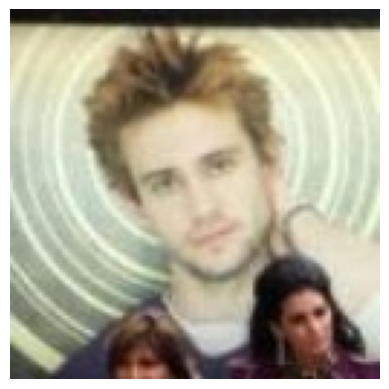

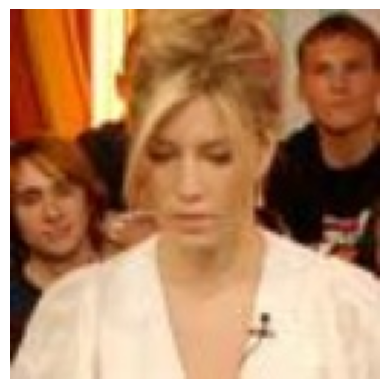

In [29]:
from matplotlib import pyplot as plt
#View some of the removed data.
dataset = DataSet(dataset_002_path)
removed_data = dataset.data[dataset.data['DeepFace_SSD_FaceDetected'] == 0]
print(f"Number of removed entries due to no face detected: {len(removed_data)}")

# view 2 images that were removed
for index, row in removed_data.head(2).iterrows():
    img_path = row['Path']
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    plt.close()

## Data Version 1.0.0
### Data preprocessing 
We would like to align all the images of the faces before we train the network.

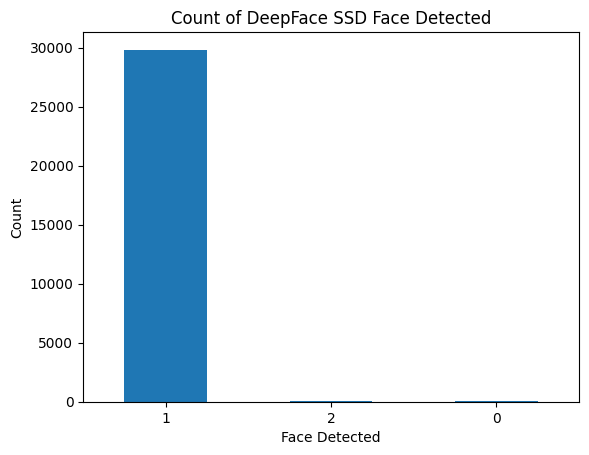

In [30]:
from matplotlib import pyplot as plt

# Load the dataset.
dataset = DataSet(dataset_002_path)
data = dataset.data
# Group by 'Category' and sum 'Value'
counts = data['DeepFace_SSD_FaceDetected'].value_counts()

# Plot the grouped data as a bar chart
counts.plot.bar(rot=0) # rot=0 prevents x-axis labels from rotating
plt.title('Count of DeepFace SSD Face Detected')
plt.xlabel('Face Detected')
plt.ylabel('Count')
plt.show()

In [31]:
import numpy as np
# Function to preprocess face images with aspect ratio preserved and centered on a 128x128 canvas.
def preprocess(face_image):
    h, w = face_image.shape[:2]

    # Scale so longest side = 128
    scale = 128 / max(h, w)
    new_w, new_h = int(w * scale), int(h * scale)
    resized = cv2.resize(face_image, (new_w, new_h))

    resized = resized * 255
    # Create a 128x128 black canvas
    canvas = np.zeros((128, 128, 3), dtype=np.uint8)

    # Compute top-left corner for centering
    x_offset = (128 - new_w) // 2
    y_offset = (128 - new_h) // 2

    # Place resized image onto canvas
    canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized

    canvas = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)
    return canvas

Creating D://braineye\dataset\dataset_v1.0.0.csv ...
Processing image: D://braineye\dataset\dataset\20\122542.jpg with age group: 20


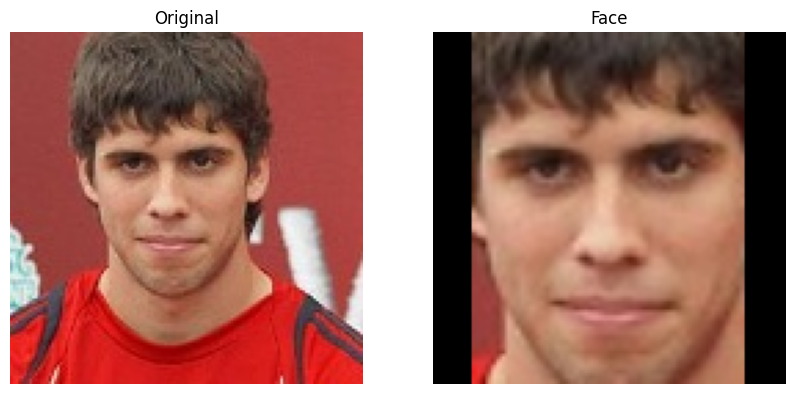

Processing image: D://braineye\dataset\dataset\20\122550.jpg with age group: 20
Processing image: D://braineye\dataset\dataset\20\122642.jpg with age group: 20
Processing image: D://braineye\dataset\dataset\20\122646.jpg with age group: 20
Processing image: D://braineye\dataset\dataset\20\122716.jpg with age group: 20
Processing image: D://braineye\dataset\dataset\20\122776.jpg with age group: 20
Processing image: D://braineye\dataset\dataset\20\122810.jpg with age group: 20
Processing image: D://braineye\dataset\dataset\20\122819.jpg with age group: 20
Processing image: D://braineye\dataset\dataset\20\122829.jpg with age group: 20
Processing image: D://braineye\dataset\dataset\20\122886.jpg with age group: 20
Processing image: D://braineye\dataset\dataset\20\122939.jpg with age group: 20
Processing image: D://braineye\dataset\dataset\20\122953.jpg with age group: 20
Processing image: D://braineye\dataset\dataset\20\122979.jpg with age group: 20
Processing image: D://braineye\dataset\d

In [32]:
import numpy as np

dataset_100_path = os.path.join(dataset_path, f"dataset_v1.0.0.csv")

if os.path.exists(dataset_100_path):
    print(f"{dataset_100_path} already exists.")
else:
    print(f"Creating {dataset_100_path} ...")
    # Load the dataset.
    dataset = DataSet(dataset_002_path)

    # Initialize the DeepFace SSD detector.
    deepface_ssd_detector = DeepFaceDetector(model_name='ssd', visualize=False)


    # Enrich the dataset with DeepFace SSD face detection results.
    dataset.add_column('Aligned_Image_Path', None)
    data = dataset.data
    filtered_df = data[data['DeepFace_SSD_FaceDetected'] == 1]


    filtered_dataset = []
    for index, row in filtered_df.iterrows():
        f_data = {}
        f_data['Id'] = row['Id']
        f_data['Age'] = row['Age']

        image_path = row['Path']
        age = row['Age']
        # print(f"Processing image: {image_path} with age group: {age}")
        face = deepface_ssd_detector.extract_face(image_path)
        output_path = os.path.join(dataset_path, "aligned_faces", str(age), os.path.basename(image_path))
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        # print(f"Saving aligned face to: {output_path}")
        face = preprocess(face[0]['face'])
        cv2.imwrite(output_path, face)

        f_data['Aligned_Image_Path'] = output_path
        filtered_dataset.append(f_data)

        if index == 0:
            # Create subplots
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns
            # Show images
            axes[0].imshow(cv2.cvtColor(cv2.imread(row['Path']), cv2.COLOR_BGR2RGB))
            axes[0].set_title('Original')
            axes[0].axis('off')
            axes[1].imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
            axes[1].set_title('Face')
            axes[1].axis('off')
            plt.show()
        if index%100 == 0:
            df = pd.DataFrame(filtered_dataset)
            df.to_csv(dataset_100_path, index=False, sep=';')

## Data Analysis
- Class distribution
- Male/Female (skipped for now) !TODO

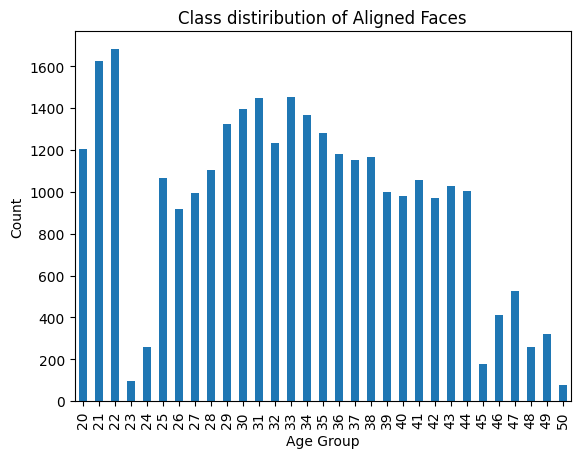

In [33]:
# Load the dataset.
dataset = DataSet(dataset_100_path)

data = dataset.data

# Group by 'Category' and sum 'Value'
counts = data['Age'].value_counts(sort=False)

# Plot the grouped data as a bar chart
counts.plot.bar() # rot=0 prevents x-axis labels from rotating
plt.title('Class distiribution of Aligned Faces')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()




> While training the network we need to consider the skewed class distribution.

### Train Set / Validation Set / Test Set

Train set is 70%
Validation set is 15%
Test set is 15%
Since the dataset is skewed we need to split it per class rather than the whole dataset.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

def save_image(image_path, age, subset):
    output_path = os.path.join(dataset_path, subset, str(age), os.path.basename(image_path))
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    # print(f"Saving aligned face to: {output_path}")
    face = cv2.imread(image_path)
    cv2.imwrite(output_path, face)

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Load the dataset.
dataset = DataSet(dataset_100_path)
df = dataset.data

# --- Stratified splitting per class ---
train_df, temp_df = train_test_split(
    df,
    stratify=df['Age'],
    test_size=(1 - train_ratio),
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    stratify=temp_df['Age'],
    test_size=test_ratio / (test_ratio + val_ratio),
    random_state=42
)

# Save the images to folder for training.
for index, data in train_df.iterrows():
    save_image(data['Aligned_Image_Path'], data['Age'], "train")

# Save the images to folder for test.
for index, data in test_df.iterrows():
    save_image(data['Aligned_Image_Path'], data['Age'], "test")

# Save the images to folder for validation.
for index, data in val_df.iterrows():
    save_image(data['Aligned_Image_Path'], data['Age'], "val")


Saving aligned face to: D://braineye\dataset\train\27\162611.jpg
Saving aligned face to: D://braineye\dataset\train\21\36594.jpg
Saving aligned face to: D://braineye\dataset\train\39\170226.jpg
Saving aligned face to: D://braineye\dataset\train\25\176970.jpg
Saving aligned face to: D://braineye\dataset\train\35\37302.jpg
Saving aligned face to: D://braineye\dataset\train\26\151861.jpg
Saving aligned face to: D://braineye\dataset\train\26\177260.jpg
Saving aligned face to: D://braineye\dataset\train\32\155034.jpg
Saving aligned face to: D://braineye\dataset\train\31\159936.jpg
Saving aligned face to: D://braineye\dataset\train\40\170910.jpg
Saving aligned face to: D://braineye\dataset\train\31\170465.jpg
Saving aligned face to: D://braineye\dataset\train\35\172998.jpg
Saving aligned face to: D://braineye\dataset\train\44\170620.jpg
Saving aligned face to: D://braineye\dataset\train\25\174386.jpg
Saving aligned face to: D://braineye\dataset\train\36\39673.jpg
Saving aligned face to: D://